# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [414]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [415]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [416]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [417]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(59, 6)


,title,price,year,link,brand,age
0,2014 chrysler town & country,6000,2014.0,https://charlottesville.craigslist.org/cto/d/w...,missing,11.0
1,2001 mercedes e320,2000,2001.0,https://charlottesville.craigslist.org/cto/d/s...,missing,24.0
2,2012 honda civic lx,5900,2012.0,https://charlottesville.craigslist.org/cto/d/h...,honda,13.0
3,toyota camry 2008,3000,2008.0,https://charlottesville.craigslist.org/cto/d/s...,toyota,17.0
4,toyota tundra 2013,16000,2013.0,https://charlottesville.craigslist.org/cto/d/s...,toyota,12.0


With the data in and wrangled, we can now do some analysis:

count       59.000000
mean     10245.745763
std      10989.514543
min       2000.000000
25%       3500.000000
50%       6500.000000
75%      11200.000000
max      62800.000000
Name: price, dtype: float64


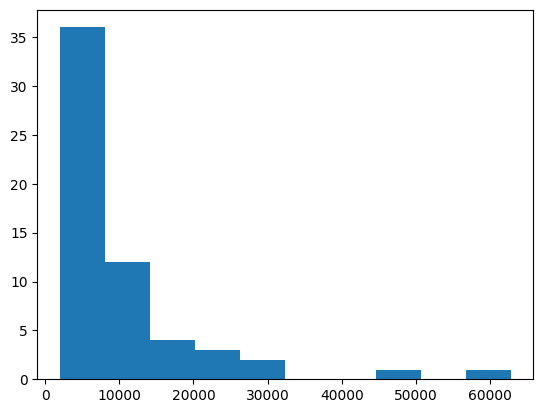

count    55.000000
mean     21.654545
std      14.985447
min       4.000000
25%      12.500000
50%      17.000000
75%      22.000000
max      68.000000
Name: age, dtype: float64


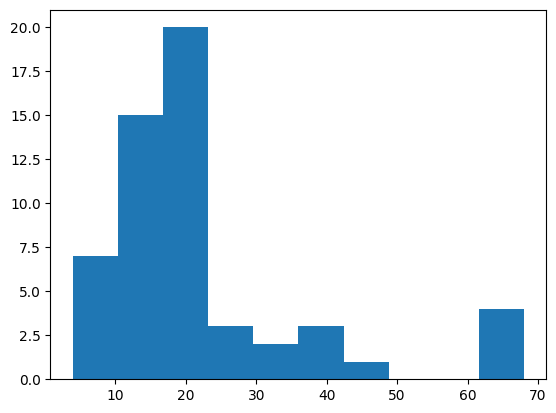

In [418]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [419]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        2.0   5250.000000   3181.980515   3000.0   4125.0   5250.0   
audi         1.0  11000.000000           NaN  11000.0  11000.0  11000.0   
bmw          2.0   8750.000000   1767.766953   7500.0   8125.0   8750.0   
chevrolet    2.0  18500.000000   5656.854249  14500.0  16500.0  18500.0   
chevy        2.0   2950.000000     70.710678   2900.0   2925.0   2950.0   
dodge        2.0   7375.000000   4772.970773   4000.0   5687.5   7375.0   
ford         8.0  15687.500000  14713.787266   4000.0   6625.0  11500.0   
gmc          2.0  16500.000000  13435.028843   7000.0  11750.0  16500.0   
honda        8.0  10500.000000   8405.440415   3000.0   5600.0   7200.0   
jeep         3.0   7900.000000   1429.160593   6250.0   7475.0   8700.0   
kia          1.0   2500.000000           NaN   2500.0   2500.0   2500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.5  11175.0   
missing     15.0   8973.266667  15819.353610   2000.0   3225.0   3500.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
tesla        1.0  26900.000000           NaN  26900.0  26900.0  26900.0   
toyota       5.0   7880.000000   5392.309338   3000.0   4500.0   5200.0   
volkswagen   2.0   4550.000000   2757.716447   2600.0   3575.0   4550.0   

                              
                75%      max  
brand                         
acura        6375.0   7500.0  
audi        11000.0  11000.0  
bmw          9375.0  10000.0  
chevrolet   20500.0  22500.0  
chevy        2975.0   3000.0  
dodge        9062.5  10750.0  
ford        18125.0  49500.0  
gmc         21250.0  26000.0  
honda       13250.0  29000.0  
jeep         8725.0   8750.0  
kia          2500.0   2500.0  
lexus       11287.5  11400.0  
missing      5124.5  62800.0  
mitsubishi   6800.0   6800.0  
tesla       26900.0  26900.0  
toyota      10700.0  16000.0  
volkswagen   5525.0   6500.0

In [420]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0  15.000000   5.656854  11.0  13.00  15.0  17.00  19.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
bmw          2.0  16.500000   0.707107  16.0  16.25  16.5  16.75  17.0
chevrolet    2.0  52.000000  22.627417  36.0  44.00  52.0  60.00  68.0
chevy        1.0  21.000000        NaN  21.0  21.00  21.0  21.00  21.0
dodge        2.0  26.500000   6.363961  22.0  24.25  26.5  28.75  31.0
ford         8.0  18.500000   7.982123   8.0  12.50  19.5  22.00  33.0
gmc          1.0  41.000000        NaN  41.0  41.00  41.0  41.00  41.0
honda        8.0  12.125000   4.611709   4.0  10.25  12.5  15.00  19.0
jeep         3.0  14.333333   3.214550  12.0  12.50  13.0  15.50  18.0
kia          1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
lexus        2.0  17.000000   5.656854  13.0  15.00  17.0  19.00  21.0
missing     13.0  29.230769  21.680075   7.0  13.00  21.0  36.00  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       5.0  18.400000   4.878524  12.0  17.00  17.0  21.00  25.0
volkswagen   2.0  33.000000  15.556349  22.0  27.50  33.0  38.50  44.0

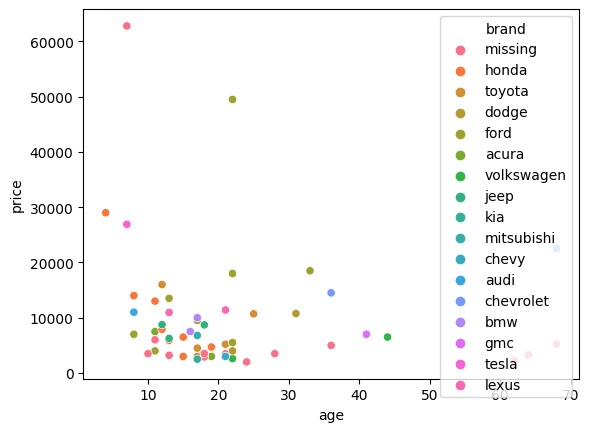

In [421]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.636425 -0.129332
log_age    -0.129332  0.350322
           log_price   log_age
log_price   1.000000 -0.281154
log_age    -0.281154  1.000000


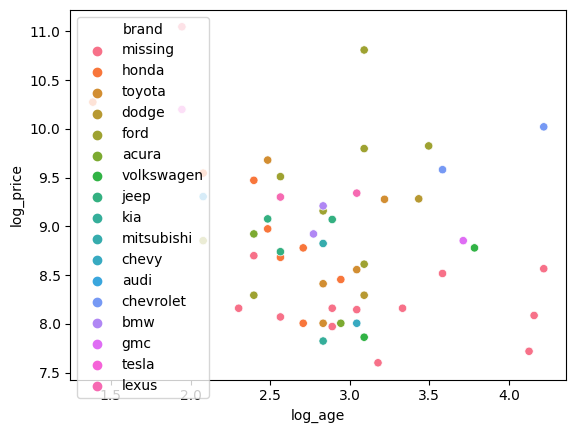

In [422]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [423]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup as soup

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}

# Making list of years of data to scrape
years = [i for i in range(2021,2025)]
# Making empty list to hold scraped data
data = []

# Looping through years
for year in years:
    # Getting html for specific years' url
    # This is statcast data for minor league baseball players
    url = f'https://baseballsavant.mlb.com/statcast-search-minors?hfPT=&hfAB=&hfGT=R%7C&hfPR=&hfZ=&hfStadium=&hfBBL=&hfNewZones=&hfPull=&hfC=&hfSea={year}%7C&hfSit=&player_type=batter&hfOuts=&hfOpponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfMo=&hfTeam=&home_road=&hfRO=&position=&hfInn=&hfBBT=&hfFlag=is%5C.%5C.tracked%7Cis%5C.%5C.remove%5C.%5C.bunts%7C&hfLevel=&metric_1=&hfTeamAffiliate=&hfOpponentAffiliate=&group_by=name&min_pitches=0&min_results=0&min_pas=150&sort_col=pitches&player_event_sort=api_p_release_speed&sort_order=desc&chk_stats_pa=on&chk_stats_hrs=on&chk_stats_k_percent=on&chk_stats_bb_percent=on&chk_stats_ba=on&chk_stats_xba=on&chk_stats_obp=on&chk_stats_slg=on&chk_stats_xslg=on&chk_stats_woba=on&chk_stats_xwoba=on&chk_stats_swing_miss_percent=on&chk_stats_launch_speed=on&chk_stats_launch_angle=on&chk_stats_bbdist=on&chk_stats_hardhit_percent=on&chk_stats_barrels_per_pa_percent=on&chk_is..tracked=on#results'
    raw = requests.get(url,headers = header)
    bsObj = soup(raw.content, 'html.parser')
    
    # Finding the table
    table = bsObj.find('table')

    # Getting the headers from the table, and adding a year header
    headers = [th.text.strip() for th in table.find('thead').find_all('th') if th.text.strip()][1:]
    headers.append('Year')

    # Finding all the rows in the table
    rows = table.find('tbody').find_all('tr')

    # Looping through the rows
    for row in rows:
        # Making list to hold the data for the row
        row_data = []
        # Going through each piece of data in the row
        for td in row.find_all('td'):
            # Checking that the row isn't an expanding element, but actual data
            if td.parent.get('class') != ['expand-child']:
                # Appending the data to the row_data list
                row_data.append(td.text.strip())
        # If the row has data
        if row_data:
            # Excluding the first two columns (rank and headshot picture), 
            # and the last columns (button on website to make a graph),
            # and adding year data for each row,
            # then adding row's data to full set
            row_data = row_data[2:]
            row_data = row_data[:-1]
            row_data.append(year)
            data.append(row_data)

# Turning data in dataframe
df = pd.DataFrame(data, columns = headers)

In [424]:
# Cleaning player names to get rid of prospect rankings
df['Player'] = df['Player'].str.replace(r'(, [^ ]+).*', r'\1', regex=True)

In [425]:
# Converting columns to numeric
df[df.columns[1:]] = df[df.columns[1:]].apply(pd.to_numeric, errors = 'coerce')

In [426]:
# Adding new column
df["PA/HR"] = (df["PA"]/df["HR"])

In [427]:
df.columns

Index(['Player', 'Pitches', 'Total', 'Pitch %', 'PA', 'HR', 'K%', 'BB%', 'BA',
       'xBA', 'OBP', 'SLG', 'xSLG', 'wOBA', 'xwOBA', 'Whiff%', 'EV (MPH)',
       'LA (°)', 'Dist (ft)', 'Hard Hit%', 'Barrel/PA%', 'Year', 'PA/HR'],
      dtype='object')

In [428]:
# Description of Average, Slugging %, wOBA
print(df["BA"].describe(), "\n\n", df["SLG"].describe(), "\n\n", df["wOBA"].describe())

count    1502.000000
mean        0.254413
std         0.038477
min         0.104000
25%         0.230000
50%         0.255000
75%         0.279000
max         0.389000
Name: BA, dtype: float64 

 count    1502.000000
mean        0.419228
std         0.083702
min         0.172000
25%         0.363000
50%         0.418000
75%         0.473000
max         0.720000
Name: SLG, dtype: float64 

 count    1502.000000
mean        0.336987
std         0.043295
min         0.185000
25%         0.308000
50%         0.338000
75%         0.364000
max         0.493000
Name: wOBA, dtype: float64


count    1502.000000
mean        8.995340
std         6.335552
min         0.000000
25%         4.000000
50%         8.000000
75%        13.000000
max        33.000000
Name: HR, dtype: float64


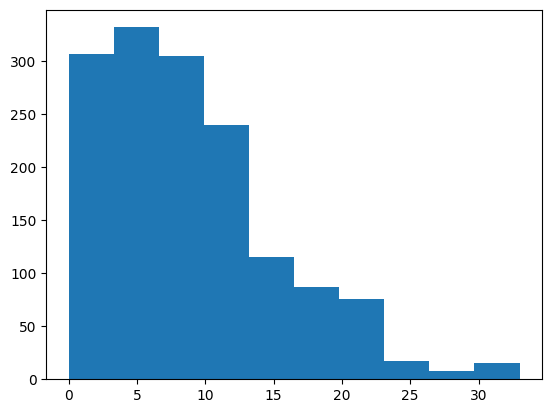

In [429]:
# Description and distribution of home runs
print(df["HR"].describe())
plt.hist(df["HR"])
plt.show()

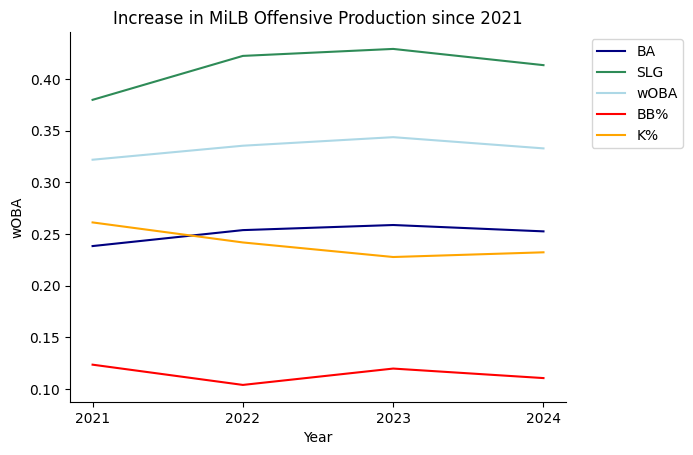

In [430]:
plt.plot(df[df.columns[1:]].groupby('Year').mean()['BA'], color = "navy", label = 'BA')
plt.plot(df[df.columns[1:]].groupby('Year').mean()['SLG'], color = "seagreen", label = 'SLG')
plt.plot(df[df.columns[1:]].groupby('Year').mean()['wOBA'], color = "lightblue", label = 'wOBA')
plt.plot(df[df.columns[1:]].groupby('Year').mean()['BB%']/100, color = "red", label = 'BB%')
plt.plot(df[df.columns[1:]].groupby('Year').mean()['K%']/100, color = "orange", label = 'K%')
plt.xlabel("Year")
plt.ylabel("wOBA")
plt.title("Increase in MiLB Offensive Production since 2021")
plt.xticks([2021, 2022, 2023, 2024])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.25,1))
plt.show()

/home/mgh2xx/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


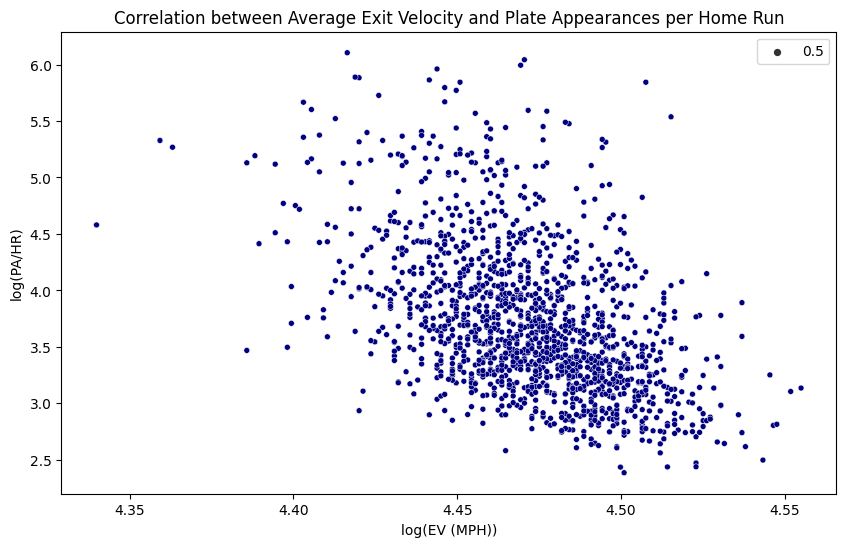

In [431]:
plt.figure(figsize = (10,6))
sns.scatterplot(np.log(df["EV (MPH)"]).values, np.log(df["PA/HR"]).values, size = 0.5, color = "navy")
plt.xlabel("log(EV (MPH))")
plt.ylabel("log(PA/HR)")
plt.title("Correlation between Average Exit Velocity and Plate Appearances per Home Run")
plt.show()

/home/mgh2xx/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


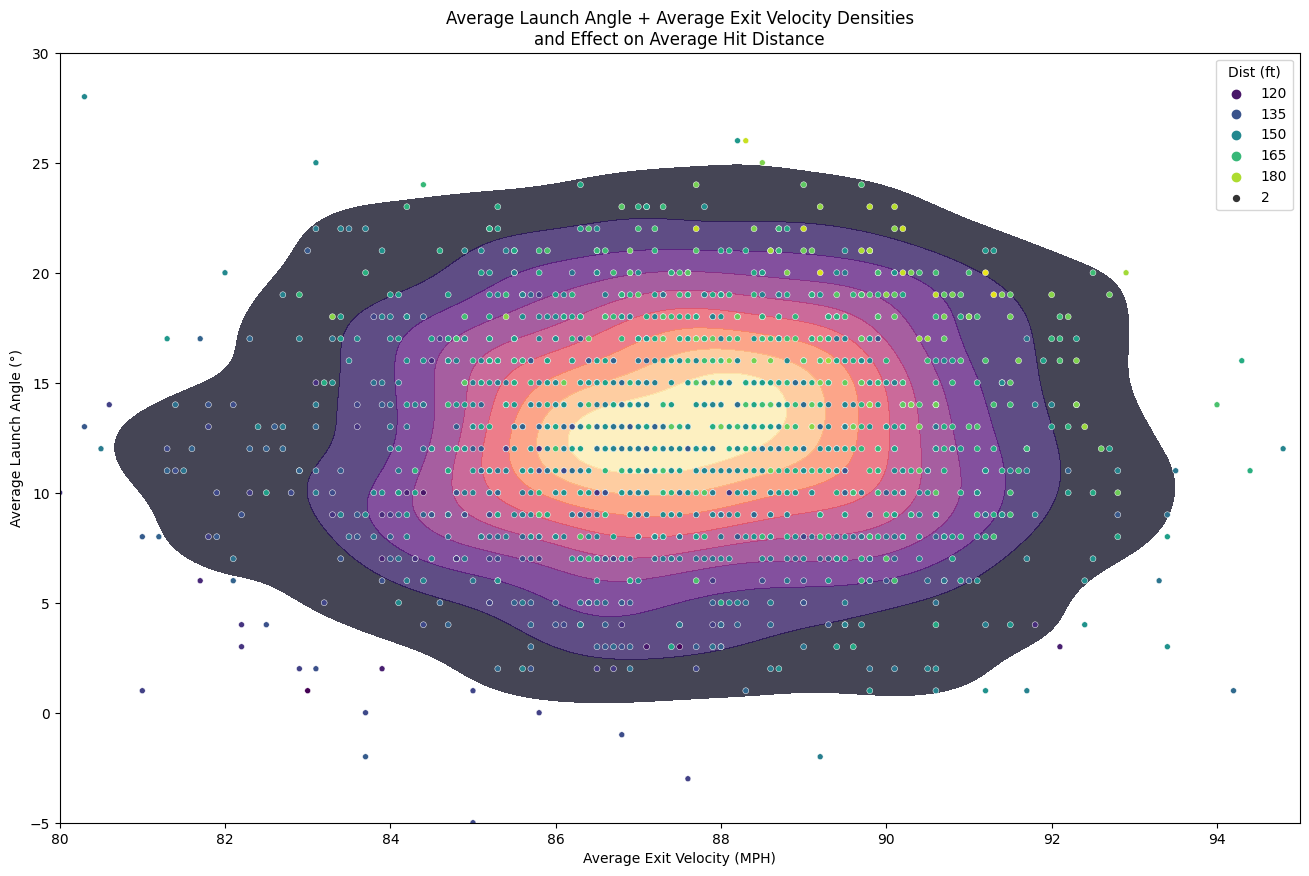

In [432]:
plt.figure(figsize = (16, 10))
sns.kdeplot(df["EV (MPH)"], df["LA (°)"], fill = True, cmap = "magma", zorder = 1, alpha = 0.75)
sns.scatterplot(data = df, x = "EV (MPH)", y = "LA (°)", hue = "Dist (ft)", edgecolors = "black", palette = "viridis", size = 2)
plt.xlabel("Average Exit Velocity (MPH)")
plt.ylabel("Average Launch Angle (°)")
plt.xlim(80, 95)
plt.ylim(-5, 30)

plt.title("Average Launch Angle + Average Exit Velocity Densities\nand Effect on Average Hit Distance")
plt.show()